**Cloning Github Repository**

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import files
import zipfile
import os

In [3]:
zip_path = "/content/dataset.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")


In [4]:
dataset_path = "/content/dataset"
positive_dir = os.path.join(dataset_path, "Positive")  # Crack images
negative_dir = os.path.join(dataset_path, "Negative")  # No-crack images

crack_images = glob(os.path.join(positive_dir, "*.jpg"))
no_crack_images = glob(os.path.join(negative_dir, "*.jpg"))

print(f"Total Crack Images: {len(crack_images)}")
print(f"Total No-Crack Images: {len(no_crack_images)}")


Total Crack Images: 20000
Total No-Crack Images: 20000


<ipython-input-5-7a83c103eb35>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="coolwarm")


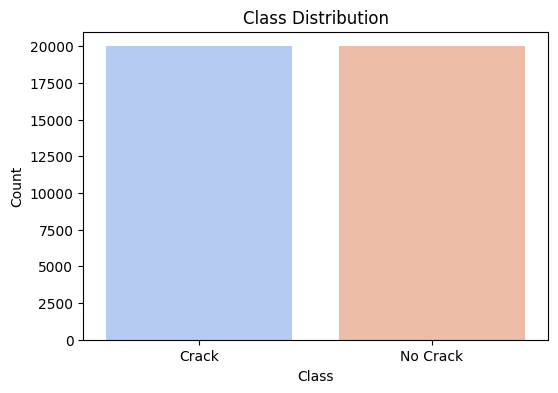

In [5]:
labels = ['Crack'] * len(crack_images) + ['No Crack'] * len(no_crack_images)

plt.figure(figsize=(6, 4))
sns.countplot(x=labels, palette="coolwarm")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

**Checking Image Sizes**

Average Image Width: 227.00, Height: 227.00


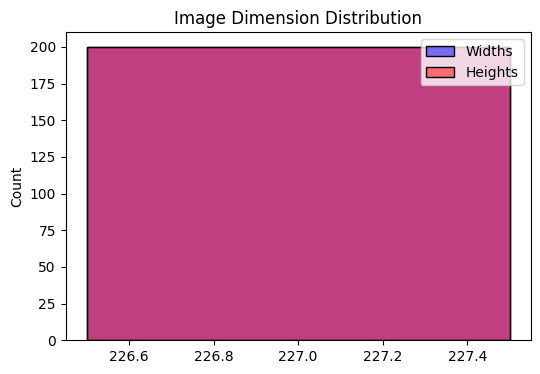

In [6]:
image_sizes = []
for img_path in crack_images[:100] + no_crack_images[:100]:
    img = Image.open(img_path)
    image_sizes.append(img.size)

widths, heights = zip(*image_sizes)
print(f"Average Image Width: {np.mean(widths):.2f}, Height: {np.mean(heights):.2f}")

plt.figure(figsize=(6, 4))
sns.histplot(widths, kde=True, color="blue", label="Widths")
sns.histplot(heights, kde=True, color="red", label="Heights")
plt.legend()
plt.title("Image Dimension Distribution")
plt.show()


**Compute Image Stats(Mean & Std)**

In [7]:
def calculate_stats(image_list):
    means, stds = [], []

    for img_path in image_list[:500]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
        means.append(np.mean(img))
        stds.append(np.std(img))

    return np.mean(means), np.mean(stds)

crack_mean, crack_std = calculate_stats(crack_images)
no_crack_mean, no_crack_std = calculate_stats(no_crack_images)

print(f"Crack Images - Mean: {crack_mean:.3f}, Std: {crack_std:.3f}")
print(f"No Crack Images - Mean: {no_crack_mean:.3f}, Std: {no_crack_std:.3f}")


Crack Images - Mean: 0.641, Std: 0.118
No Crack Images - Mean: 0.715, Std: 0.034


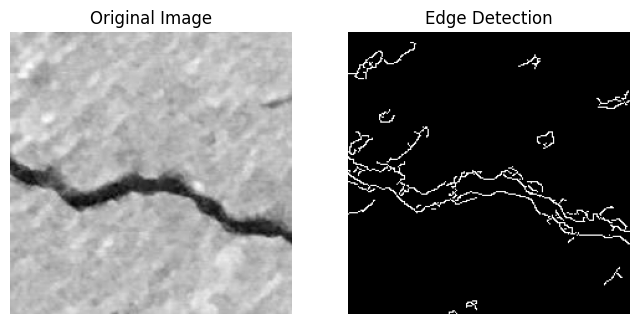

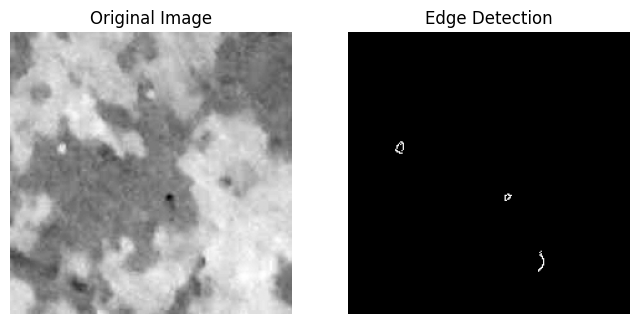

In [8]:
def show_edges(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, threshold1=50, threshold2=150)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Edge Detection")
    plt.axis("off")

    plt.show()

show_edges(crack_images[0])
show_edges(no_crack_images[0])


Loading Dataset

In [9]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

augment_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Augmented
train_augmented = augment_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Validation generator
val_data = augment_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


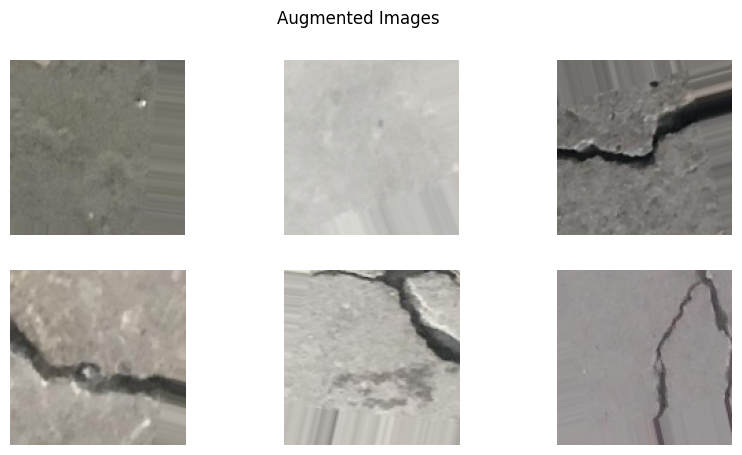

In [10]:
import matplotlib.pyplot as plt

augmented_images, _ = next(train_augmented)

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
plt.suptitle("Augmented Images")
plt.show()

Inception Based-Model

In [11]:
from tensorflow.keras import layers, models, regularizers, Input
from tensorflow.keras.optimizers import Adam

# Inception module
def inception_module(x, filters):
    f1, f2, f3 = filters

    conv1x1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(x)

    conv3x3 = layers.Conv2D(f2, (3, 3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(x)

    conv5x5 = layers.Conv2D(f3, (5, 5), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(x)

    maxpool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    maxpool = layers.Conv2D(f1, (1, 1), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(maxpool)

    output = layers.concatenate([conv1x1, conv3x3, conv5x5, maxpool], axis=-1)
    return output
# new input
input_layer = Input(shape=(128, 128, 3))

# Initial Conv and MaxPooling with Dropout
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(0.001))(input_layer)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Dropout(0.3)(x)

# Blocks
x = inception_module(x, [32, 64, 64])
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Dropout(0.3)(x)

x = inception_module(x, [64, 128, 128])
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Dropout(0.3)(x)

x = inception_module(x, [128, 256, 256])
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Dropout(0.3)(x)

# Fully Connected Layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │          2,080 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │        102,464 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 32)     │          2,080 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 192)    │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 192)    │              0 │ concatenate[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16, 16, 192)    │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 192)    │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 64)     │         12,352 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │        221,312 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        614,528 │ dropout_1[0][0]        │
├──────────────────────

 Total params: 7,601,217 (29.00 MB)

 Trainable params: 7,601,217 (29.00 MB)

 Non-trainable params: 0 (0.00 B)

**Training**

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "improved_inception_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

epochs = 30

history = model.fit(
    train_augmented,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[checkpoint_callback],
    verbose=1
)

model.save("improved_inception_trained_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8204 - loss: 1.7407
Epoch 1: val_accuracy improved from -inf to 0.97613, saving model to improved_inception_checkpoint.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 210s 194ms/step - accuracy: 0.8206 - loss: 1.7402 - val_accuracy: 0.9761 - val_loss: 0.8524
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9800 - loss: 0.6698
Epoch 2: val_accuracy improved from 0.97613 to 0.97838, saving model to improved_inception_checkpoint.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 194s 194ms/step - accuracy: 0.9800 - loss: 0.6696 - val_accuracy: 0.9784 - val_loss: 0.3943
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9833 - loss: 0.3182
Epoch 3: val_accuracy improved from 0.97838 to 0.98450, saving model to improved_inception_checkpoint.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 187s 187ms/step - accuracy: 0.9833 - loss: 0.3182 - val_accuracy: 0.9845 - val_loss: 0.2156
Epoch 4/30
1000/1000 ━━━━

In [14]:
model.save('inception_trained_model_improved.h5')
print("Model saved successfully!")

Model saved successfully!


In [15]:
# Last Epoch
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

# Best Results
best_train_acc = max(history.history['accuracy'])
best_val_acc = max(history.history['val_accuracy'])

# Number of the best epoch
best_train_epoch = history.history['accuracy'].index(best_train_acc) + 1
best_val_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")
print(f"Best Training Accuracy: {best_train_acc * 100:.2f}% at epoch {best_train_epoch}")
print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}% at epoch {best_val_epoch}")


Final Training Accuracy: 99.48%
Final Validation Accuracy: 99.70%
Best Training Accuracy: 99.60% at epoch 25
Best Validation Accuracy: 99.77% at epoch 22


**Plotting**

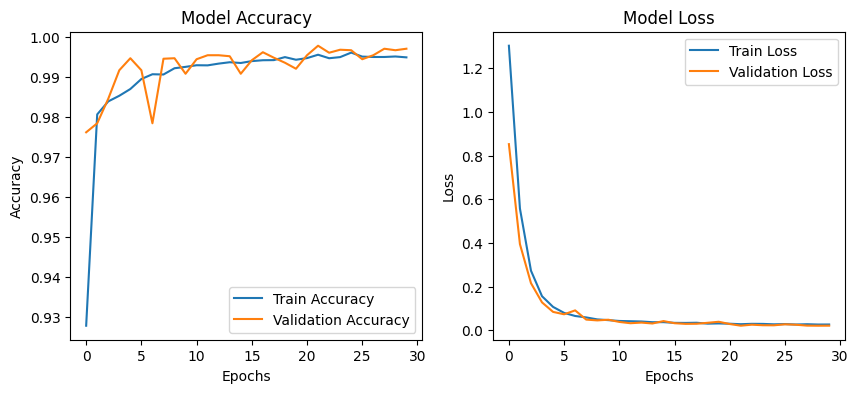

In [16]:
import matplotlib.pyplot as plt

# Accuracy & loss
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")

plt.show()


Precision, Recall, F1-Score

In [17]:
from sklearn.metrics import classification_report
import numpy as np

y_true = val_data.classes
y_pred_probs = model.predict(val_data)
y_pred = (y_pred_probs > 0.5).astype("int32").reshape(-1)

# Classification report
print(classification_report(y_true, y_pred, target_names=val_data.class_indices.keys()))

250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      4000
    Positive       1.00      1.00      1.00      4000

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



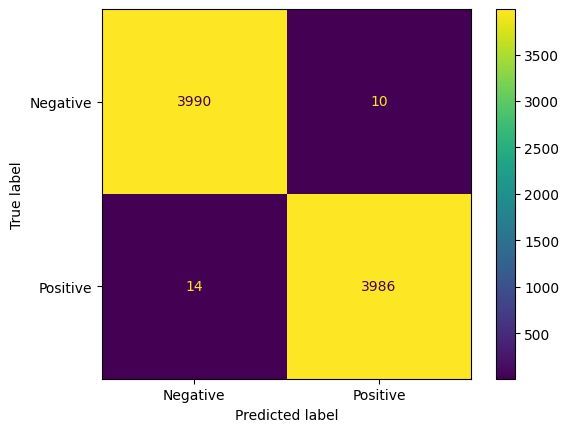

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.class_indices.keys())
disp.plot()
plt.show()